# Freshwater anomaly

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def ncdatetime(days):
    basedate = datetime(1800,1,1)
    _dt = (basedate + relativedelta(days=int(days))).replace(day=15)
    return _dt

### Load datasets

#### HadOBS EN4 (2000-2015)

In [3]:
# Open Hadobs EN4 monthly fields
nc = xr.open_dataset('hadobs_en4_salinity.nc',decode_times=False)

# Convert time
nc.time.values = map(lambda n: ncdatetime(n), nc.time.values)

# Change longitude (-180 to 180)
nc_l = nc.sel(lon=slice(180,380))
nc_l['lon'] = nc_l['lon'] - 360
nc_r = nc.sel(lon=slice(0,180))

# Save rearranged array in new dataset
ds = xr.concat([nc_l,nc_r],dim='lon')

del nc_l,nc_r

#### Area

In [6]:
nc = xr.open_dataset('hadobs_en4_area.nc')
ds['area'] = nc.area

In [7]:
ds.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

### Set spatial and temporal range

In [8]:
south = 45
north = 90
west = -85
east = 30

tstart = '1950-01-15'
tend = '2012-12-15'

In [9]:
psal = ds.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

In [10]:
# psal_ref: baseline for computing anomalies
psal_ref = psal.sel(time=slice('1950-01-15','1959-12-15')).groupby('time.month').mean('time')

In [11]:
# Calculate monthly averages for each pentad timeframe
psal_5357 = psal.sel(time=slice('1953-01-15','1957-12-15')).groupby('time.month').mean('time')
psal_5862 = psal.sel(time=slice('1958-01-15','1962-12-15')).groupby('time.month').mean('time')
psal_6367 = psal.sel(time=slice('1963-01-15','1967-12-15')).groupby('time.month').mean('time')
psal_6872 = psal.sel(time=slice('1968-01-15','1972-12-15')).groupby('time.month').mean('time')
psal_7377 = psal.sel(time=slice('1973-01-15','1977-12-15')).groupby('time.month').mean('time')
psal_7882 = psal.sel(time=slice('1978-01-15','1982-12-15')).groupby('time.month').mean('time')
psal_8387 = psal.sel(time=slice('1983-01-15','1987-12-15')).groupby('time.month').mean('time')
psal_8892 = psal.sel(time=slice('1988-01-15','1992-12-15')).groupby('time.month').mean('time')
psal_9397 = psal.sel(time=slice('1993-01-15','1997-12-15')).groupby('time.month').mean('time')
psal_9802 = psal.sel(time=slice('1998-01-15','2002-12-15')).groupby('time.month').mean('time')
psal_0307 = psal.sel(time=slice('2003-01-15','2007-12-15')).groupby('time.month').mean('time')
psal_0812 = psal.sel(time=slice('2008-01-15','2012-12-15')).groupby('time.month').mean('time')

In [12]:
# Calculate mean salinity for each pentad and combine to single data array
psal_pentad = xr.concat([psal_5357.mean('month'),psal_5862.mean('month'),psal_6367.mean('month'),
                         psal_6872.mean('month'),psal_7377.mean('month'),psal_7882.mean('month'),
                         psal_8387.mean('month'),psal_8892.mean('month'),psal_9397.mean('month'),
                         psal_9802.mean('month'),psal_0307.mean('month'),psal_0812.mean('month')], 'pentad')

In [13]:
# Calculate mean salinity anomaly for each pentad and combine to single data array
psal_pentad_anom = xr.concat([(psal_ref-psal_5357).mean('month'),(psal_ref-psal_5862).mean('month'),
                              (psal_ref-psal_6367).mean('month'),(psal_ref-psal_6872).mean('month'),
                              (psal_ref-psal_7377).mean('month'),(psal_ref-psal_7882).mean('month'),
                              (psal_ref-psal_8387).mean('month'),(psal_ref-psal_8892).mean('month'),
                              (psal_ref-psal_9397).mean('month'),(psal_ref-psal_9802).mean('month'),
                              (psal_ref-psal_0307).mean('month'),(psal_ref-psal_0812).mean('month')], 'pentad')

## Freshwater anomaly
The amount of dilution, $\Delta F$, for the water column at each gridpoint is evaluated from depth-averaged salinity differences relative to the baseline time period ($S – S_{ref}$) accumulated in discrete layers with height $dz$:
$$ \Delta F_{x,y} = \frac{\Delta S_{x,y}\;H_{x,y}}{S_{avg}}$$

where $\Delta S_{x,y}$ is
$$\Delta S_{x,y} = \frac{\sum{(S_{ref} - S)\,dz}}{\sum\,dz}$$

and $S_{avg}$ is the depth-averaged salinity for the water column with height $H_{x,y}$.

## Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [14]:
depth_bnds = ds.depth_bnds.sel(time=slice(tstart,tend),lon=slice(west,east)).mean('time')

In [15]:
dz = (depth_bnds[:,:,1]-depth_bnds[:,:,0]).transpose('depth','lon')

In [16]:
H = ((psal_pentad/psal_pentad)*dz).sum('depth')

In [17]:
S_avg = (psal_pentad * dz).sum('depth')/H

#Hxy = ((psal_ref.mean('month')/psal_ref.mean('month'))*dz).sum('depth')
#S_avg = (psal_ref.mean('month') * dz).sum('depth')/Hxy

In [18]:
dS = (psal_pentad_anom * dz).sum('depth')/H

In [19]:
dF = (dS*H)/S_avg

### Spatially integrate to obtain the liquid freshwater content (LFWC)
The volumetric census of freshwater anomalies (in km$^3$) is evaluated by integrating the area-weighted anomaly over the entire gridded domain:

$$\Delta F = \sum \Delta F_{x,y}\;dxdy $$

In [20]:
spg_lats = [50, 65, 65, 50]
spg_lons = [-60, -60, -10, -10]

In [21]:
dF_spg = dF.sel(lat=slice(np.min(spg_lats),np.max(spg_lats)),
                lon=slice(np.min(spg_lons),np.max(spg_lons)))

lfwc_spg = (dF_spg * ds.area).sum(dim=['lat','lon'])

# Convert from m^3 to km^3
lfwc_spg = lfwc_spg*1e-9

In [22]:
lfwc_spg = xr.DataArray(lfwc_spg.values,coords=[pd.date_range('1955-06-30','2010-06-30',freq='60M')],dims=['time'])

In [23]:
df = pd.read_csv('Curry_and_Mauritzen_2005_fig02_fw_subpolar.csv',header=None,names = ["time", "dF"])
df = df.reset_index()
df.time = pd.DatetimeIndex(df.time)
df = df.set_index(['time'])
df = df.drop('index', 1)

In [24]:
ds_en = xr.open_dataset('hadobs_en4_lfwc_spg.nc')

In [25]:
lfwc = ds_en.lfwc
lfwc_anom = lfwc - lfwc.mean('time')

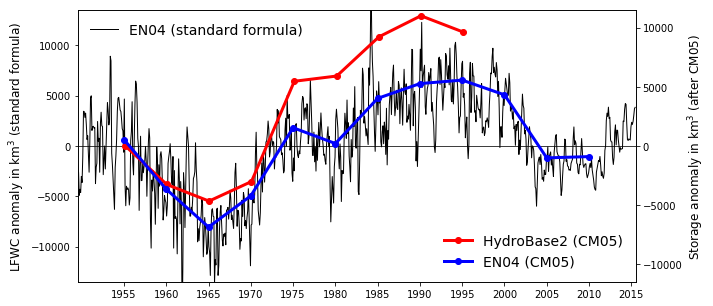

In [41]:
fig, ax1 = plt.subplots(figsize=(10,5))
    
ax1.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
ax1.plot(lfwc_anom.time, lfwc_anom, lw=1, color='k',linestyle='-',label='EN04 (standard formula)')
ax1.set_xlim(['1950-01-01','2015-12-31'])
ax1.set_ylim([-13500,13500])
ax1.set_xticks(pd.date_range('1955-06-30','2015-06-30',freq='60M'))
ax1.set_ylabel(r'LFWC anomaly in km$^3$ (standard formula)',color='k',fontsize=12)
for tl in ax1.get_yticklabels():
    tl.set_color('k')
ax1.legend(loc='upper left',frameon=False, fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
ax2.plot(df.index, df.dF, lw=3, color='r', linestyle='-',marker='o', label='HydroBase2 (CM05)')
ax2.plot(lfwc_spg.time, lfwc_spg, lw=3, color='b', linestyle='-',marker='o', label='EN04 (CM05)')

ax2.set_xlim(['1950-01-01','2015-12-31'])
ax2.set_ylim([-11500, 11500])
ax2.set_ylabel(r'Storage anomaly in km$^3$ (after CM05)',color='k',fontsize=12)
for tl in ax2.get_yticklabels():
    tl.set_color('k')

ax2.legend(loc='lower right',frameon=False, fontsize=14)

plt.savefig('figure.png')
plt.show()

In [27]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


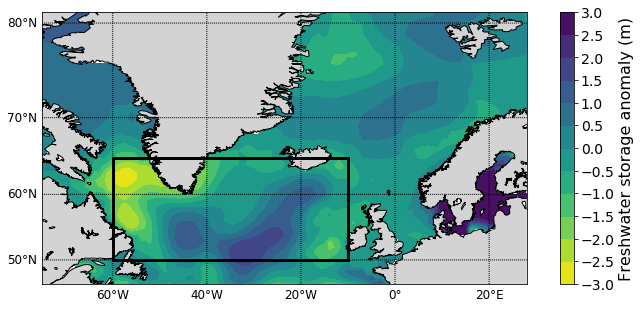

In [28]:
fig = plt.figure(figsize=(12,5))

m = Basemap(projection='mill', llcrnrlat=46, urcrnrlat=81, llcrnrlon=-75, urcrnrlon=28, 
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-60,90,10),labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(-180,180,20),labels=[0,0,0,1],fontsize=12)
lon, lat = np.meshgrid(dF.lon.values,dF.lat.values)
x, y = m(lon, lat)
p = m.contourf(x,y,np.clip(dF[-1],-3,3),cmap='viridis_r',vmin=-3,vmax=3,
               levels = np.arange(-3,3.5,0.5))

x, y = m(spg_lons, spg_lats)
patch = Polygon(zip(x,y), facecolor='none',edgecolor='k', linewidth=3)
plt.gca().add_patch(patch)

cb = fig.colorbar(p,ticks=np.arange(-3,3.5,0.5))
cb.set_label(r'Freshwater storage anomaly (m)',fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()

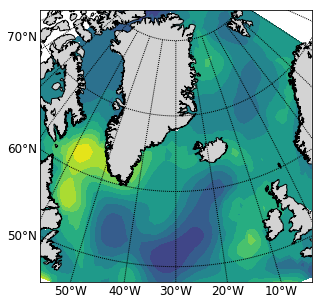

In [29]:
fig = plt.figure(figsize=(12,5))

m = Basemap(projection='laea',lat_ts=50,lat_0=66,lon_0=-30,width=4000000,height=4000000,resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(0,360,10), labels=[0,0,0,1],fontsize=12)
lon, lat = np.meshgrid(dF.lon.values,dF.lat.values)
x, y = m(lon, lat)
p = m.contourf(x,y,np.clip(dF[-1],-3,3),cmap='viridis_r',vmin=-3,vmax=3,
               levels = np.arange(-3,3.5,0.5))

plt.show()